In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import dataframe_image as dfi
from json import loads, dumps
from ipywidgets import widgets
from IPython.display import display

In [2]:
from glob import glob

def gather_runs(append=False):
    glob_path = "./implementation/test/history/**/*.json"

    runs = []
    for run_output_filepath in glob(glob_path, recursive=True):
        with open(run_output_filepath) as run_output:
            run_json = loads(run_output.read())
            runs.append(run_json)

    if append:
        with open("./data.json", "r") as data_file:
            print(data_file)
            data = loads(data_file.read())
            runs.extend(data)

    if not runs:
        raise Exception("No runs found. Keeping old data.")
    else:
        print(f"Found {len(runs)} runs")

    with open("./data.json", "w") as data_file:
        data_file.write(dumps(runs, indent=2))

# gather_runs()

In [3]:
df = None
def update_df():
    global df

    with open("./data.json") as data_file:
        runs = loads(data_file.read())

    if not runs:
        raise Exception("No runs found")
    else:
        print(f"Loading {len(runs)} runs")

    newDF = pd.DataFrame(runs)
    newDF = newDF.rename(columns={
        "lang": "language"
    })

    newDF = newDF.assign(
        # Super fragile replace but works for now
        payload=lambda df: df["payload"].map(
            lambda payload: loads(payload.replace(";", ","))),

        runtime=lambda df: df["runtime"].astype(float),
        roundTripTime=lambda df: df["roundTripTime"].astype(float),
        newcontainer=lambda df: df["newcontainer"].astype(int),

        filter=lambda df: df["payload"].map(
            lambda payload: f"{payload['filter']} x {payload.get('repeats', 1)}"),
        filename=lambda df: df["payload"].map(lambda payload: payload["key"]),
        containerState=lambda df: np.where(
            df["newcontainer"] == 1, "cold", "hot"
        ),
        language=lambda df: df["language"].map({
            "java": "Java",
            "node.js": "JavaScript",
        }),

        pixelDimensions=lambda df: df["filename"].map(
            lambda filename: tuple(map(int, filename.split("@")[0].split("x")))),
        pixelAmount=lambda df: df["pixelDimensions"].map(
            lambda dimensions: dimensions[0] * dimensions[1]),

        shortName=lambda df:
        df["filename"].map(lambda filename: filename.split("-")[1].strip()[:-4]),

        fileID=lambda df: df["shortName"] + " " + df["pixelDimensions"].astype(str),
    )
    df = newDF

update_df()

display(widgets.Button(description="Update Data Frame",
        button_style="success", icon="refresh",
        on_click=lambda _: update_df(), layout=widgets.Layout(width="30%")))


Loading 8651 runs


Button(button_style='success', description='Update Data Frame', icon='refresh', layout=Layout(width='30%'), st…

In [4]:
def create_global_widgets():
    global_widgets = {}
    for (columnName, columnData) in df.items():
        try:
            if type(columnName) == str:
                global_widgets[columnName] = widgets.Dropdown(
                    options=columnData.unique(),
                    description=columnName,
                    disabled=False,
                )
        except Exception as e:
            print(columnName, ":", e)
    return global_widgets

columns_to_display = {
    "cpuType", "language", "functionName", "containerState", "filter",
    "pixelAmount", "shortName", "fileID", "filename",
}
global_widgets = create_global_widgets()
display(*(
    global_widget
    for column, global_widget
    in global_widgets.items()
    if column in columns_to_display
))

payload : unhashable type: 'dict'
key : Invalid selection: value not found
bucket : Invalid selection: value not found
message : Invalid selection: value not found


Dropdown(description='cpuType', options=('Intel(R) Xeon(R) Processor @ 2.50GHz - Model 63', 'Intel(R) Xeon(R) …

Dropdown(description='language', options=('Java', 'JavaScript'), value='Java')

Dropdown(description='functionName', options=('imageProcessingJava', 'imageProcessingJavaScript'), value='imag…

Dropdown(description='filter', options=('flipVertical x 1', 'greyscale x 1', 'soften x 4', 'soften x 8', 'soft…

Dropdown(description='filename', options=('50x50@5KB - osu.jpg', '256x256@17KB - husky.jpg', '700x466@384KB - …

Dropdown(description='containerState', options=('hot', 'cold'), value='hot')

Dropdown(description='pixelAmount', options=(2500, 65536, 326200, 2304000, 8294400, 19961856), value=2500)

Dropdown(description='shortName', options=('osu', 'husky', 'vietfood', 'deathstar', 'mountains', 'lanterns'), …

Dropdown(description='fileID', options=('osu (50, 50)', 'husky (256, 256)', 'vietfood (700, 466)', 'deathstar …

Dropdown(description='filename', options=('50x50@5KB - osu.jpg', '256x256@17KB - husky.jpg', '700x466@384KB - …

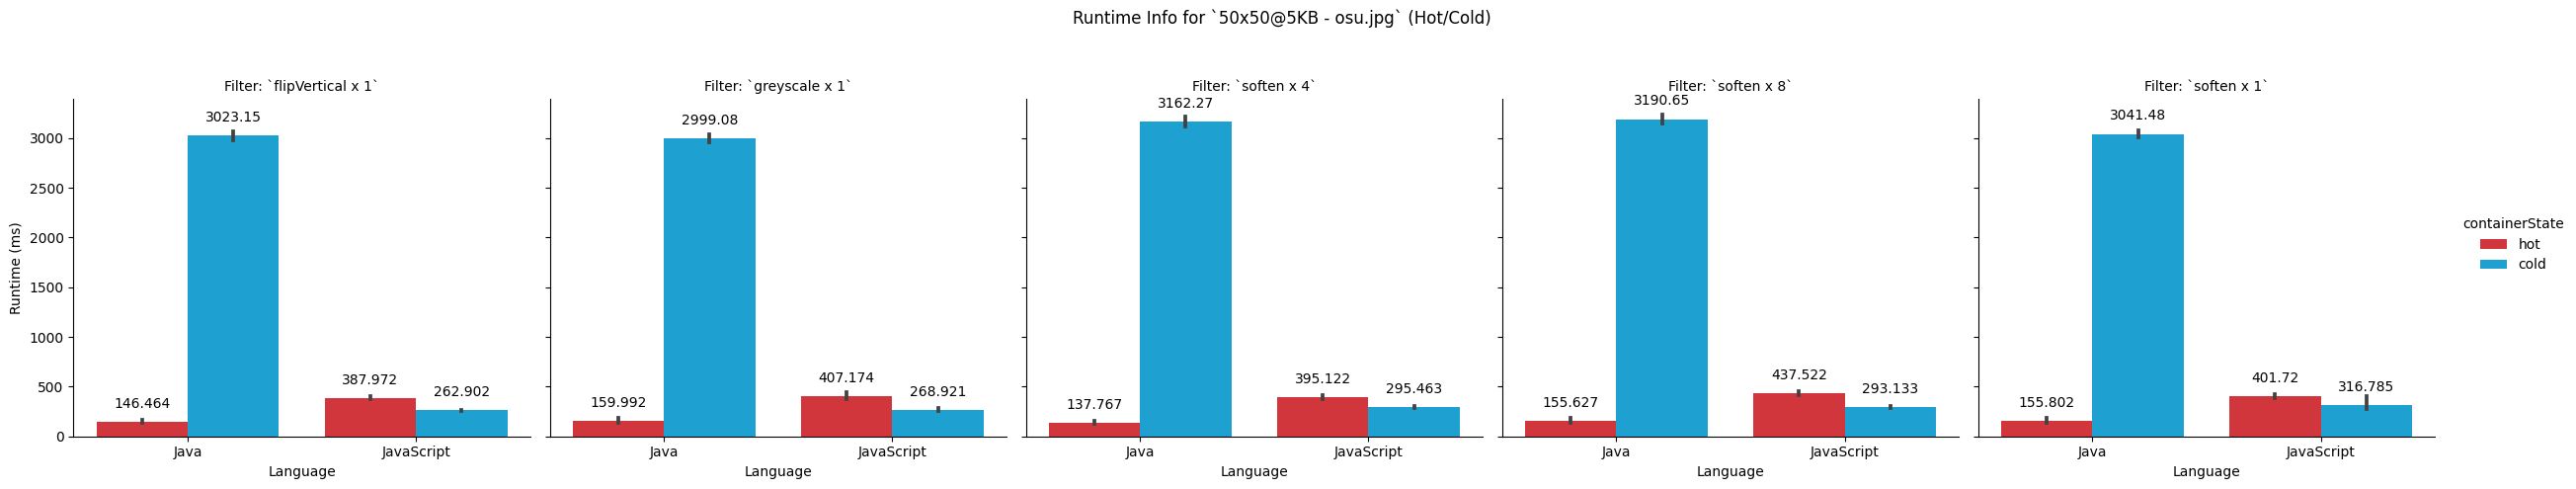

In [5]:
filename = global_widgets["filename"].value

data = df[
    (df["filename"] == filename) &
    True
]

results = sns.catplot(
    data,
    kind="bar",
    x="language", y="runtime",
    hue="containerState",
    col="filter", palette=["#eb1c24", "#00adef"],
)
results.set_ylabels("Runtime (ms)")
results.set_xlabels("Language")
results.figure.subplots_adjust(top=0.8)
results.figure.suptitle(f"Runtime Info for `{filename}` (Hot/Cold)")
results.set_titles("Filter: `{col_name}`")

for ax in results.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, padding=8)

display(global_widgets["filename"], results)

Dropdown(description='filename', options=('50x50@5KB - osu.jpg', '256x256@17KB - husky.jpg', '700x466@384KB - …

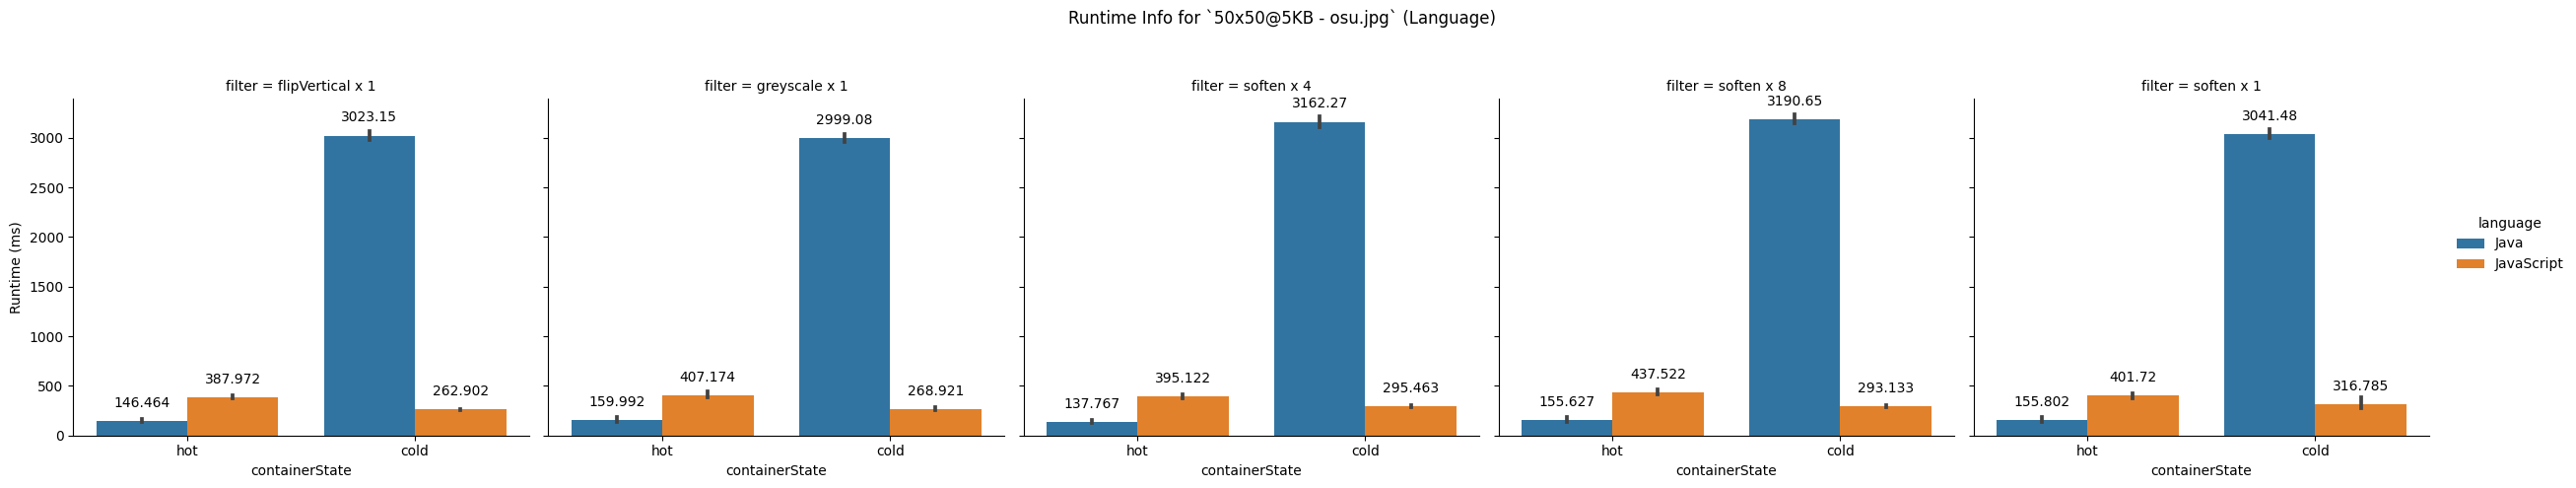

In [6]:
filename = global_widgets["filename"].value

data = df[
    (df["filename"] == filename) &
    True
]

results = sns.catplot(
    data,
    kind="bar",
    x="containerState", y="runtime",
    hue="language",
    col="filter",
)
results.set_ylabels("Runtime (ms)")
results.figure.subplots_adjust(top=0.8)
results.figure.suptitle(f"Runtime Info for `{filename}` (Language)")

for ax in results.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, padding=8)

display(global_widgets["filename"], results)

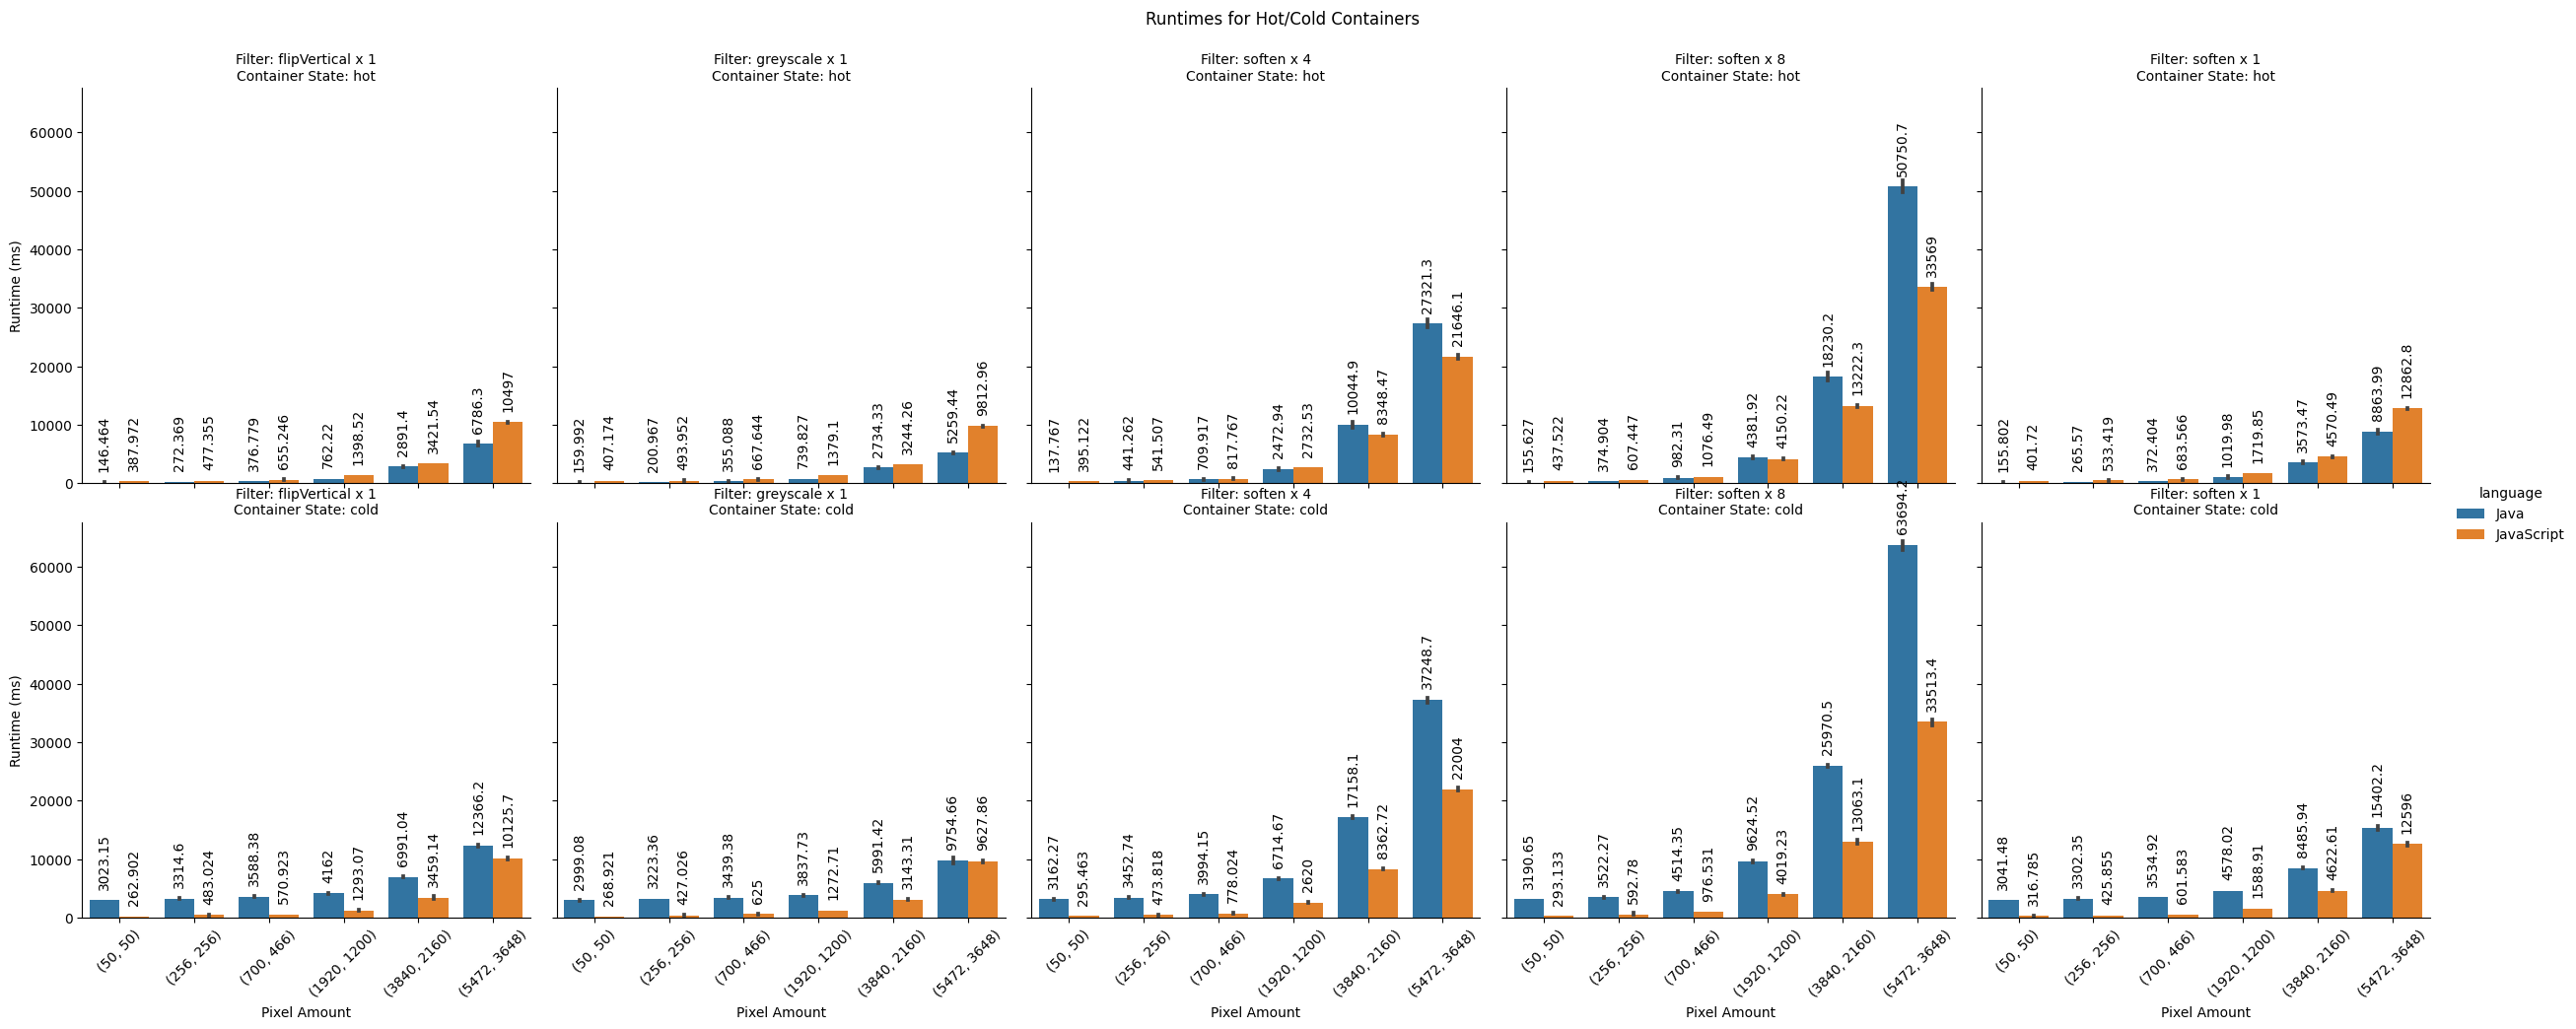

In [7]:
hot_cold_results = sns.catplot(
    df, x="pixelDimensions", y="runtime", hue="language",
    col="filter", row="containerState", kind="bar",
)
hot_cold_results.set_axis_labels("Pixel Amount", "Runtime (ms)")
hot_cold_results.set_titles("Filter: {col_name}\nContainer State: {row_name}")
hot_cold_results.figure.subplots_adjust(top=0.9)
hot_cold_results.figure.suptitle("Runtimes for Hot/Cold Containers")
hot_cold_results.tick_params(axis="x", rotation=45)

for ax in hot_cold_results.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, padding=8, rotation=90)

hot_cold_results

In [8]:
grouped_columns = [
    # "cpuType",
    "filename", "filter", "containerState", "language",
]
data=df[
    (df["filename"] == global_widgets["filename"].value)
]

runtime_results = data.groupby(grouped_columns)["runtime"] \
    .agg(["mean", "std", "count"])
runtime_results = runtime_results.rename(columns={
    "mean": "average runtime (ms)",
    "std": "standard deviation",
    "count": "sample size",
})

display(global_widgets["filename"], runtime_results)

Dropdown(description='filename', options=('50x50@5KB - osu.jpg', '256x256@17KB - husky.jpg', '700x466@384KB - …

average runtime (ms)  \
filename            filter           containerState language                           
50x50@5KB - osu.jpg flipVertical x 1 cold           Java                 3023.146341   
                                                    JavaScript            262.902439   
                                     hot            Java                  146.464286   
                                                    JavaScript            387.972477   
                    greyscale x 1    cold           Java                 2999.081081   
                                                    JavaScript            268.921053   
                                     hot            Java                  159.992126   
                                                    JavaScript            407.173554   
                    soften x 1       cold           Java                 3041.482143   
                                                    JavaScript            316.784615   
                                     hot            Java                  155.802198   
                                                    JavaScript            401.720000   
                    soften x 4       cold           Java                 3162.272727   
                                                    JavaScript            295.463415   
                                     hot            Java                  137.766667   
                                                    JavaScript            395.121622   
                    soften x 8       cold           Java                 3190.653846   
                                                    JavaScript            293.133333   
                                     hot            Java                  155.626506   
                                                    JavaScript            437.522222   

                                                                standard deviation  \
filename            filter           containerState language                         
50x50@5KB - osu.jpg flipVertical x 1 cold           Java                144.021797   
                                                    JavaScript           20.701214   
                                     hot            Java                 89.755517   
                                                    JavaScript           95.178435   
                    greyscale x 1    cold           Java                137.738556   
                                                    JavaScript           37.640821   
                                     hot            Java                140.167445   
                                                    JavaScript          185.605167   
                    soften x 1       cold           Java                149.713665   
                                                    JavaScript          253.688508   
                                     hot            Java                121.456094   
                                                    JavaScript          115.789698   
                    soften x 4       cold           Java                196.855131   
                                                    JavaScript           27.467342   
                                     hot            Java                 73.499537   
                                                    JavaScript          105.359782   
                    soften x 8       cold           Java                160.381761   
                                                    JavaScript           25.436731   
                                     hot            Java                111.223979   
                                                    JavaScript          104.157101   

                                                                sample size  
filename            filter           containerState language                 
50x50@5KB - osu.jpg flipVertical x 1 cold           Java                 41  


In [9]:
for shortName in df["shortName"].unique():
    grouped_columns = [
        # "cpuType",
        "filename", "filter", "containerState", "language",
    ]
    data=df[
        (df["shortName"] == shortName)
    ]

    runtime_results = data.groupby(grouped_columns)["runtime"] \
        .agg(["mean", "std", "count"])
    runtime_results = runtime_results.rename(columns={
        "mean": "average runtime (ms)",
        "std": "standard deviation",
        "count": "sample size",
    })

    # dfi.export(runtime_results, f"runtime_results_{shortName}.png", max_rows=-1)

In [10]:
grouped_columns = [
    # "cpuType",
    "filename", "filter", "containerState", "language",
]

runtime_results = df.groupby(grouped_columns)["runtime"] \
    .agg(["mean", "std", "count"])
runtime_results = runtime_results.rename(columns={
    "mean": "average runtime (ms)",
    "std": "standard deviation",
    "count": "sample size",
})

# pd.set_option("display.max_rows", None)
runtime_results

average runtime (ms)  \
filename                        filter           containerState language                           
1920x1200@958KB - deathstar.jpg flipVertical x 1 cold           Java                 4162.000000   
                                                                JavaScript           1293.065217   
                                                 hot            Java                  762.220183   
                                                                JavaScript           1398.523364   
                                greyscale x 1    cold           Java                 3837.729730   
...                                                                                          ...   
700x466@384KB - vietfood.jpg    soften x 4       hot            JavaScript            817.767123   
                                soften x 8       cold           Java                 4514.352941   
                                                                JavaScript            976.530612   
                                                 hot            Java                  982.309524   
                                                                JavaScript           1076.494118   

                                                                            standard deviation  \
filename                        filter           containerState language                         
1920x1200@958KB - deathstar.jpg flipVertical x 1 cold           Java                164.193306   
                                                                JavaScript           62.212683   
                                                 hot            Java                265.146792   
                                                                JavaScript          158.872403   
                                greyscale x 1    cold           Java                143.215581   
...                                                                                        ...   
700x466@384KB - vietfood.jpg    soften x 4       hot            JavaScript           97.600165   
                                soften x 8       cold           Java                250.104684   
                                                                JavaScript           55.043960   
                                                 hot            Java                301.584250   
                                                                JavaScript          128.741585   

                                                                            sample size  
filename                        filter           containerState language                 
1920x1200@958KB - deathstar.jpg flipVertical x 1 cold           Java                 44  
                                                                JavaScript           46  
                                                 hot            Java                109  
                                                                JavaScript          107  
                                greyscale x 1    cold           Java                 37  
...                                                                                 ...  
700x466@384KB - vietfood.jpg    soften x 4       hot            JavaScript           73  
                                soften x 8       cold           Java                 51  
                                                                JavaScript           49  
                                                 hot            Java                 84  
                                                                JavaScript           85  

[120 rows x 3 columns]

Dropdown(description='language', options=('Java', 'JavaScript'), value='Java')

Dropdown(description='filter', options=('flipVertical x 1', 'greyscale x 1', 'soften x 4', 'soften x 8', 'soft…

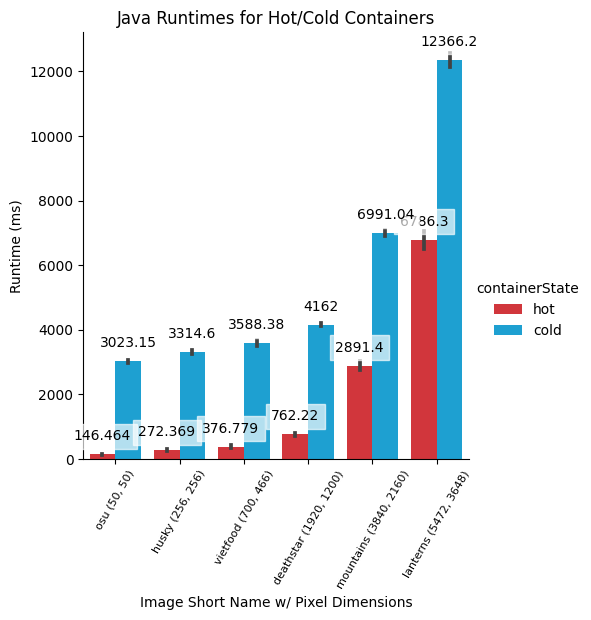

In [11]:
hot_cold = sns.catplot(
    df[
        (df["language"] == global_widgets["language"].value)
        & (df["filter"] == global_widgets["filter"].value)
    ],
    x="fileID", y="runtime",
    hue="containerState",
    palette=["#eb1c24", "#00adef"],
    kind="bar",
)
hot_cold.set(
    title=f"{global_widgets['language'].value} Runtimes for Hot/Cold Containers",
    
)
hot_cold.set_axis_labels("Image Short Name w/ Pixel Dimensions", "Runtime (ms)")
hot_cold.set_ylabels("Runtime (ms)")
hot_cold.tick_params(axis="x", rotation=60, labelsize=8)

for ax in hot_cold.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, padding=8, rotation=0, backgroundcolor="#FFFFFFAA")

display(
    hot_cold,
    global_widgets["language"],
    global_widgets["filter"],
)

Dropdown(description='language', options=('Java', 'JavaScript'), value='Java')

Dropdown(description='filter', index=2, options=('flipVertical x 1', 'greyscale x 1', 'soften x 4', 'soften x …

Dropdown(description='filename', options=('50x50@5KB - osu.jpg', '256x256@17KB - husky.jpg', '700x466@384KB - …

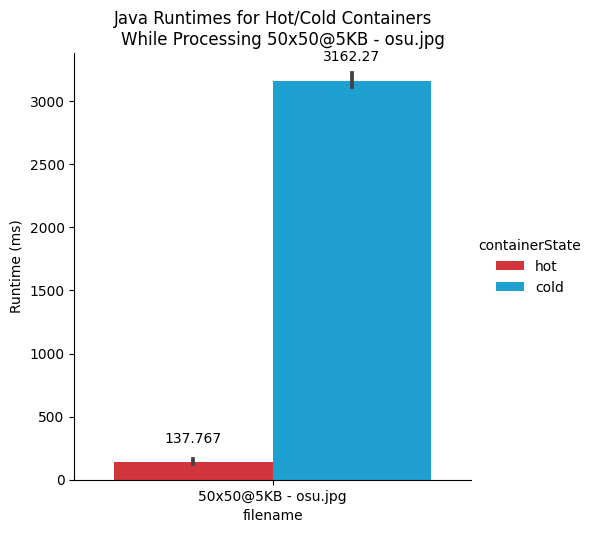

In [18]:
title = f"""
    {global_widgets['language'].value} Runtimes for Hot/Cold Containers
    While Processing {global_widgets['filename'].value}
""".strip()
hot_cold_specific = sns.catplot(
    df[
        (df["language"] == global_widgets["language"].value)
        & (df["filter"] == global_widgets["filter"].value)
        & (df["filename"] == global_widgets["filename"].value)
    ],
    x="filename", y="runtime",
    hue="containerState", hue_order=["hot", "cold"],
    palette=["#eb1c24", "#00adef"],
    kind="bar",
)
hot_cold_specific.set(title=title)
hot_cold_specific.set_ylabels("Runtime (ms)")

for ax in hot_cold_specific.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, padding=12)

display(
    hot_cold_specific,
    global_widgets["language"],
    global_widgets["filter"],
    global_widgets["filename"],
)

In [23]:
# import matplotlib.pyplot as plt

# for language in df["language"].unique():
#     for filter in df["filter"].unique():
#         for shortName in df["shortName"].unique():
#             title = f"""
# {global_widgets['language'].value} Runtimes for Hot/Cold Containers
# While Processing {global_widgets['filename'].value}
#             """.strip()
#             hot_cold_specific = sns.catplot(
#                 df[
#                     (df["language"] == language) &
#                     (df["filter"] == filter) &
#                     (df["shortName"] == shortName)
#                 ],
#                 x="filename", y="runtime",
#                 hue="containerState", hue_order=["hot", "cold"],
#                 palette=["#eb1c24", "#00adef"],
#                 kind="bar",
#             )
#             hot_cold_specific.set(title=title)
#             hot_cold_specific.set_axis_labels("Filename", "Runtime (ms)")

#             for ax in hot_cold_specific.axes.flat:
#                 for container in ax.containers:
#                     ax.bar_label(container, padding=10)

#             last = hot_cold_specific
#             hot_cold_specific.savefig(f"./ignore/{language}_{filter}_{shortName}.png")
#             plt.close(hot_cold_specific.figure)

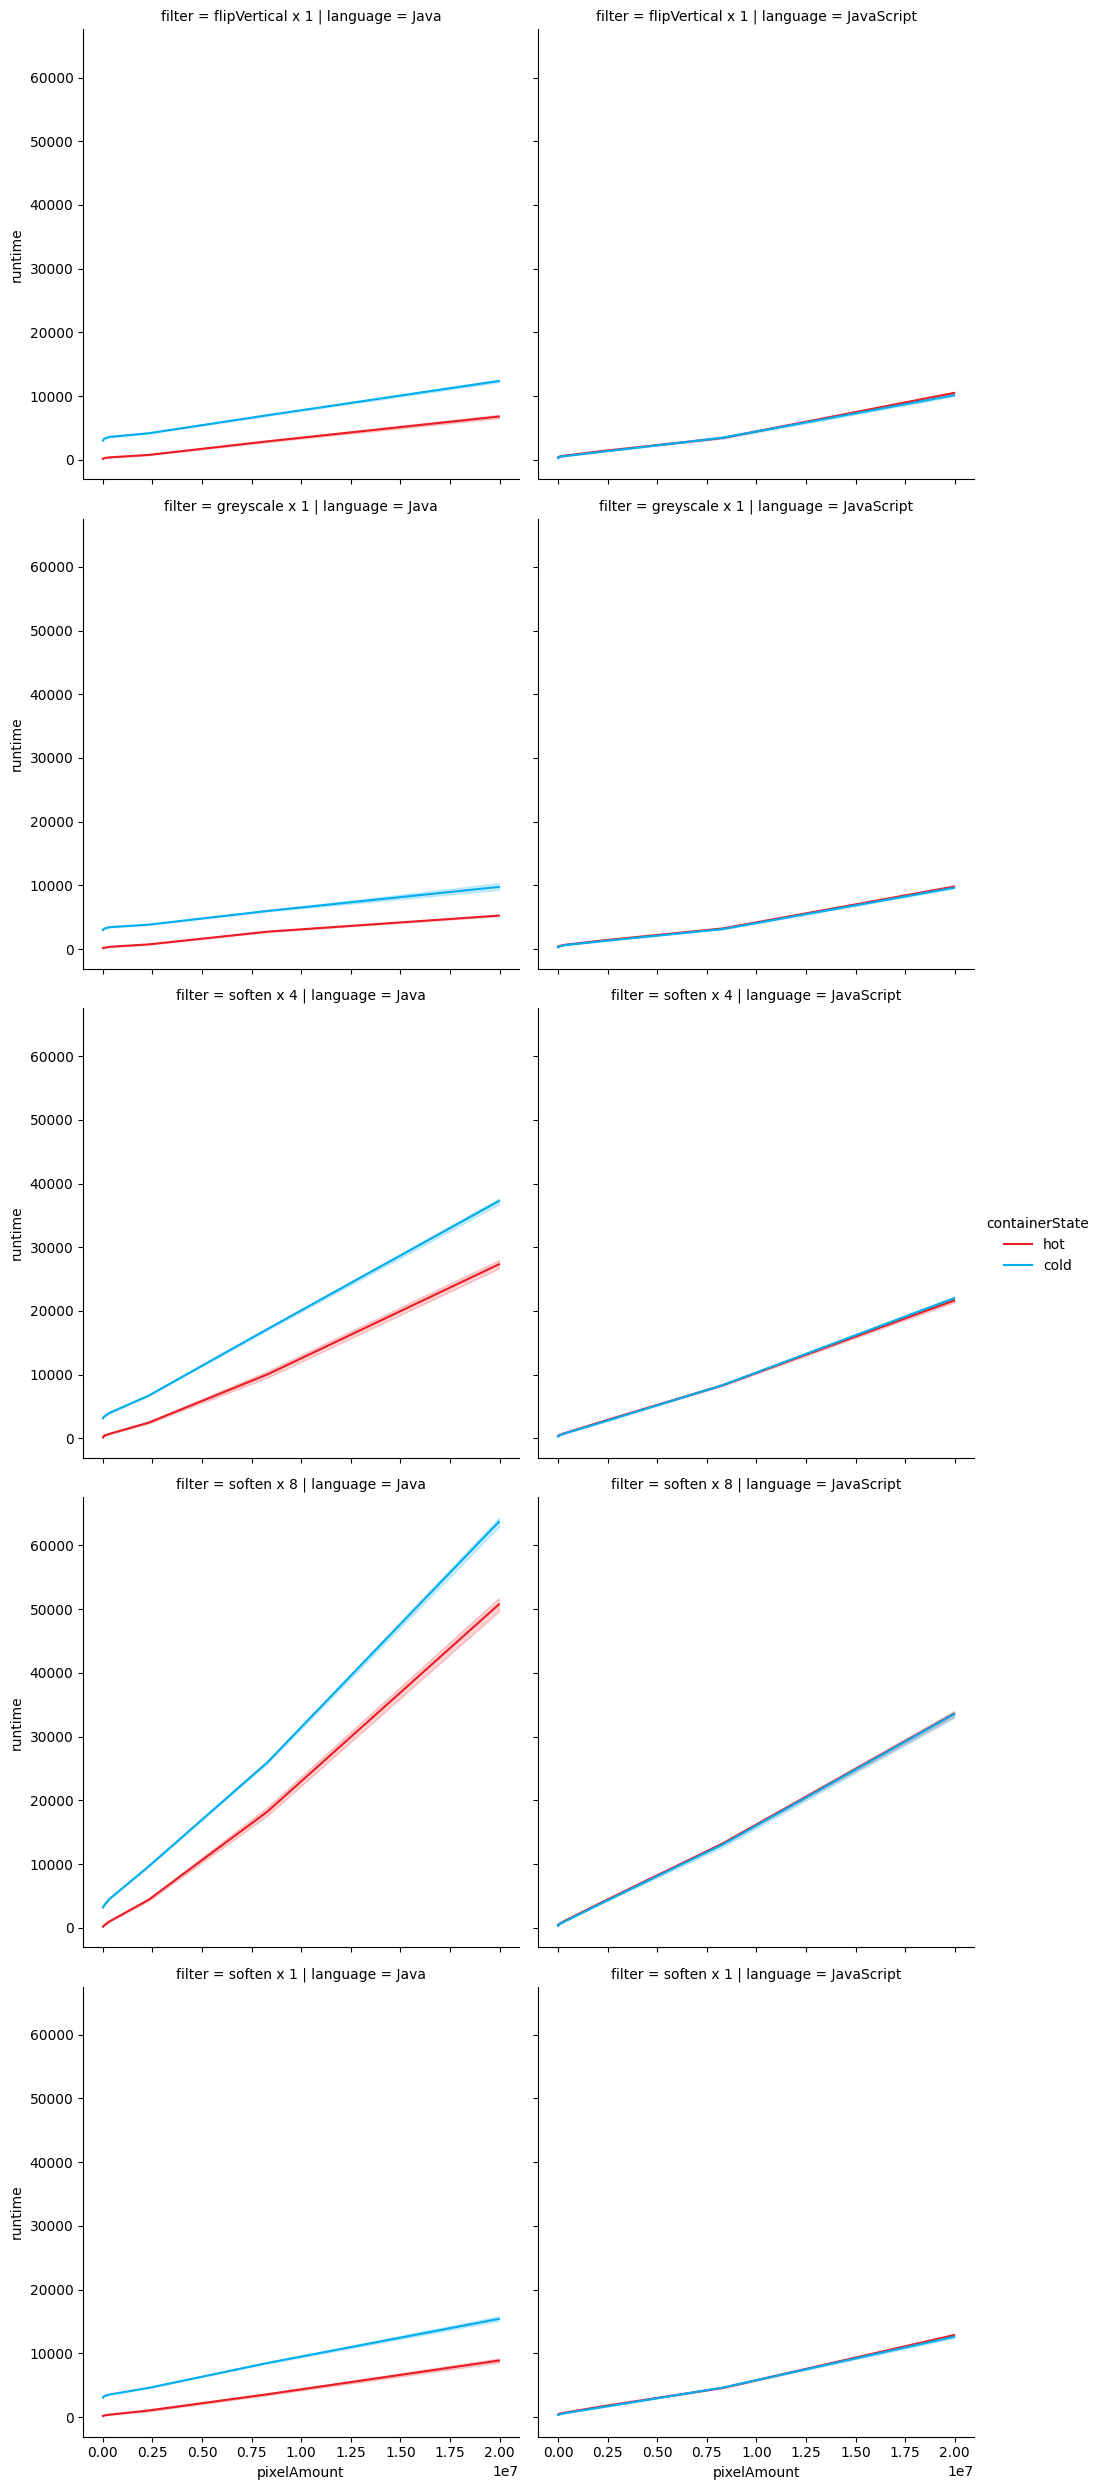

In [24]:
graph = sns.relplot(
    df,
    x="pixelAmount", y="runtime",
    col="language", row="filter",
    hue="containerState",
    palette=["#eb1c24", "#00adef"],
    kind="line",
)

graph